# Training an CNN to automatically classify storm morphology

### Preprocessing

1) Set the number of classes and size of the image (including the '3rd' dimension, even though these are greyscale)

2) Read in the files using the get_example_data utility

3) Normalize the data by 80 dBZ

4) Verify the shape of the training, validation, and testing datasets

5) Transform the "single number" classifications into keras friendly arrays.

In [1]:
#Based on examples from the Keras documentation
import numpy as np
np.random.seed(42)
from tensorflow import keras
from tensorflow.keras import layers
import pickle
from svrimg.utils.get_images import get_example_data

num_classes = 6
input_shape = (136, 136, 1)

(x_train, y_train) = get_example_data('training', data_dir="../data/pkls/")
(x_val, y_val) = get_example_data('validation', data_dir="../data/pkls/")
(x_test, y_test) = get_example_data('testing', data_dir="../data/pkls/")

#Normalize by 80 dBZ
x_train = x_train.astype("float32") / 80
x_test = x_test.astype("float32") / 80
x_val = x_val.astype("float32") / 80

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_val.shape[0], "validate samples")
print(x_test.shape[0], "test samples")

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (1331, 136, 136, 1)
1331 train samples
110 validate samples
300 test samples


### Create a simple 3 convolutional and 1 dense layer CNN

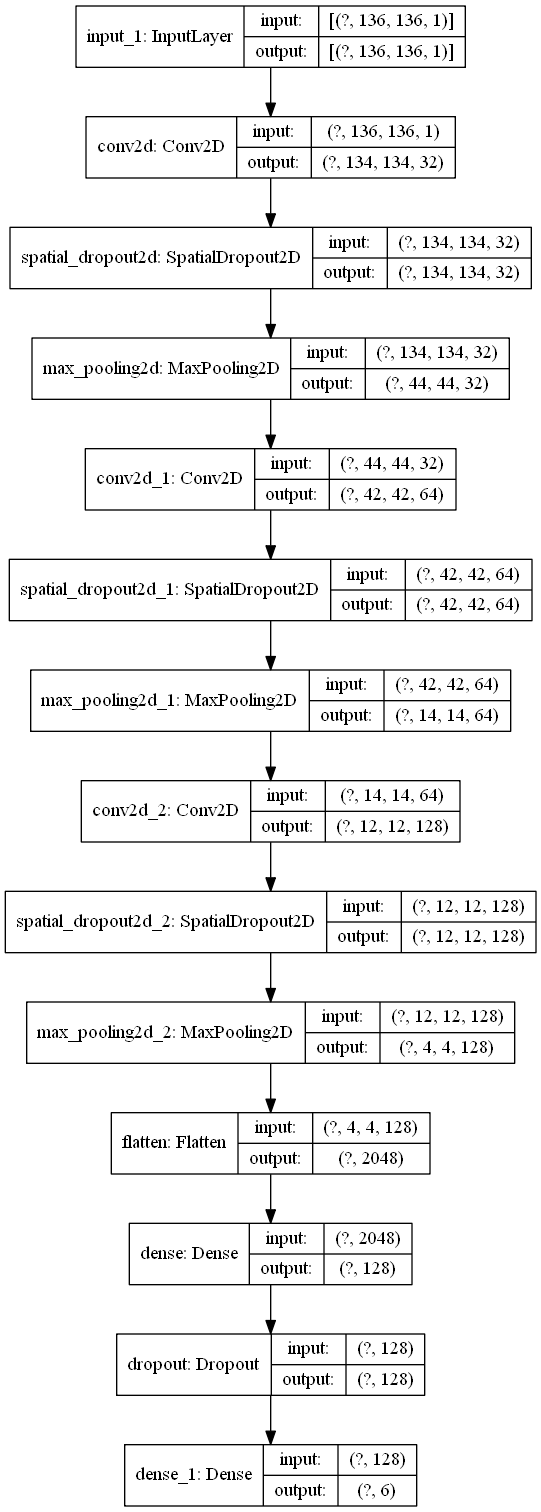

In [2]:
model = keras.Sequential(
    [
        keras.Input(shape=(136, 136, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.SpatialDropout2D(0.3),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.SpatialDropout2D(0.3),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.SpatialDropout2D(0.3),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.6),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

keras.utils.plot_model(model, show_shapes=True)

### Use Data Augmentation to reduce overfitting

We can show how this works with one example.  

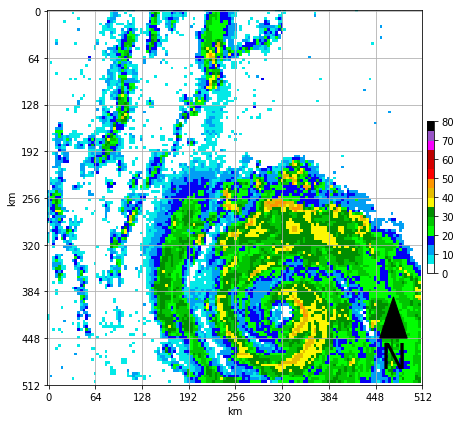

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 8

from svrimg.utils.map_helper import radar_colormap, draw_box_plot
from matplotlib.colors import BoundaryNorm

cmap = radar_colormap()
classes = np.array(list(range(0, 85, 5)))
norm = BoundaryNorm(classes, ncolors=cmap.N)

sample = x_test[52]
ax = plt.subplot(1,1,1)
draw_box_plot(ax, sample.squeeze()*80)

We should try to avoid shifting the image left and right, because the location of the 
storm report is right in the middle of each image.  Instead, rotate the image and zoom in and out slightly.
It is also important to ask yourself, does the image augmentation make sense?

We can visualize this with 9 randomly generated examples.

Using TensorFlow backend.


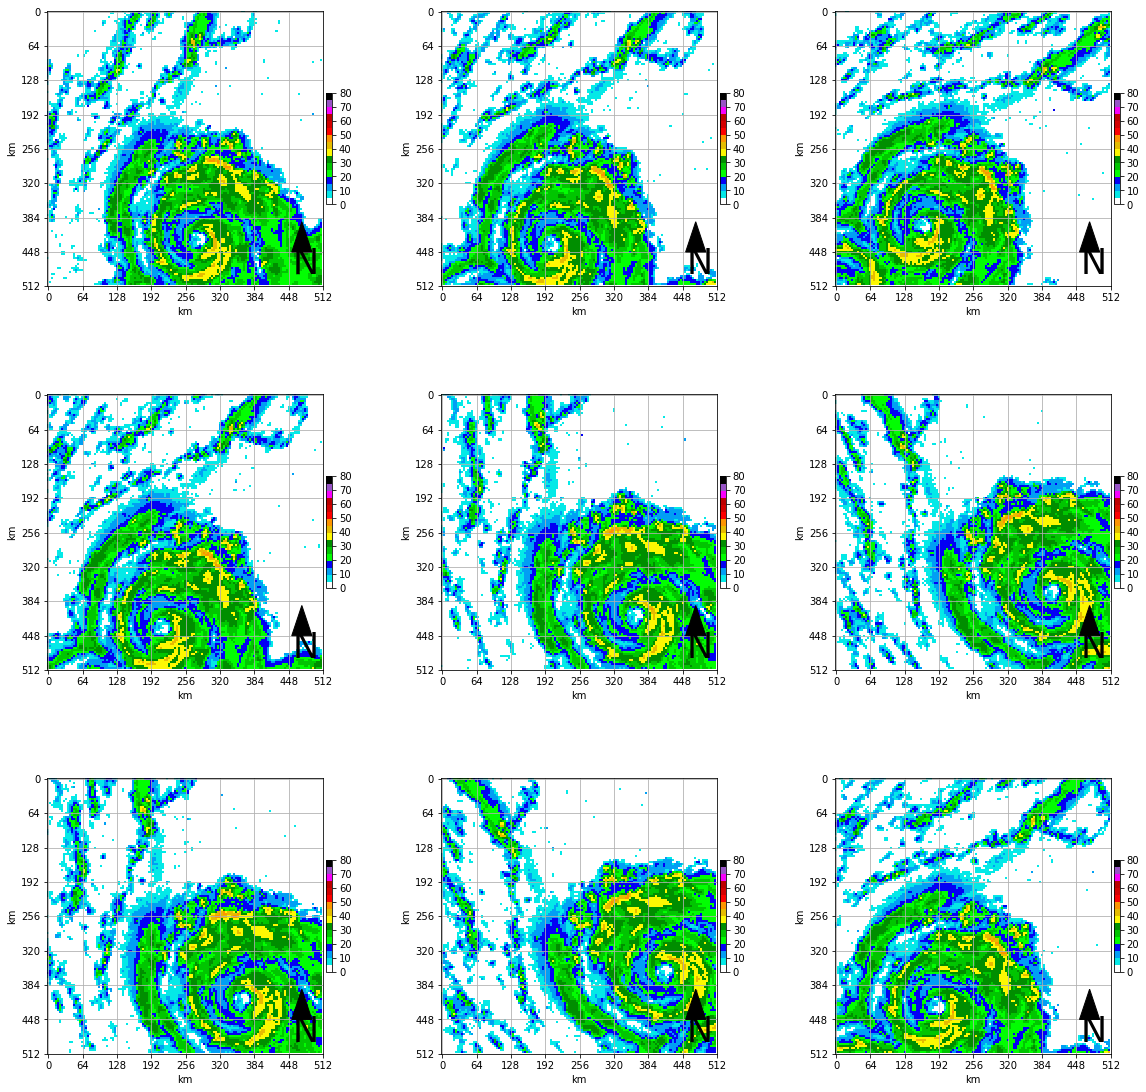

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims

plt.rcParams['figure.figsize'] = 20, 20

samples = expand_dims(sample, 0)

datagen = ImageDataGenerator(rotation_range=55, zoom_range=[0.9,1.0], fill_mode="reflect")

aug_imgs = datagen.flow(samples, batch_size=1)

for i in range(9):
   
    ax = plt.subplot(3,3,i+1)

    batch = aug_imgs.next()

    draw_box_plot(ax, batch[0].squeeze()*80)

Create an image generator for the training data and validation data and pass these values into model.fit().  Wait for the model to finish 100 epochs and test how it did!

Note: modify the "workers" argument depending on what kind of CPU you have.  This was tested on a 20 core machine.

In [5]:
epochs = 100

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                              epochs=epochs, validation_data=(x_val, y_val), workers=8)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 42 steps, validate on 110 samples
Epoch 1/100
42/42 [==============================] - 4s 104ms/step - loss: 1.3260 - accuracy: 0.4771 - val_loss: 0.9010 - val_accuracy: 0.7273
Epoch 2/100
42/42 [==============================] - 1s 28ms/step - loss: 1.0469 - accuracy: 0.6281 - val_loss: 0.8009 - val_accuracy: 0.6818
Epoch 3/100
42/42 [==============================] - 1s 23ms/step - loss: 0.9465 - accuracy: 0.6619 - val_loss: 0.7362 - val_accuracy: 0.7636
Epoch 4/100
42/42 [==============================] - ETA: 0s - loss: 0.8757 - accuracy: 0.71 - 1s 24ms/step - loss: 0.8824 - accuracy: 0.7115 - val_loss: 0.6336 - val_accuracy: 0.7636
Epoch 5/100
42/42 [==============================] - 1s 24ms/step - loss: 0.8109 - accuracy: 0.7340 - val_loss: 0.5961 - val_accuracy: 0.8000
Epoch 6/100
42/42 [==============================] - 1s 25ms/step - loss: 0.7836 - accuracy: 0.7506 - 

42/42 [==============================] - 1s 24ms/step - loss: 0.3676 - accuracy: 0.8820 - val_loss: 0.3363 - val_accuracy: 0.8818
Epoch 54/100
42/42 [==============================] - 1s 24ms/step - loss: 0.3442 - accuracy: 0.9008 - val_loss: 0.3120 - val_accuracy: 0.8909
Epoch 55/100
42/42 [==============================] - 1s 22ms/step - loss: 0.3365 - accuracy: 0.8978 - val_loss: 0.3017 - val_accuracy: 0.9091
Epoch 56/100
42/42 [==============================] - 1s 24ms/step - loss: 0.3352 - accuracy: 0.8941 - val_loss: 0.3035 - val_accuracy: 0.9091
Epoch 57/100
42/42 [==============================] - 1s 24ms/step - loss: 0.3326 - accuracy: 0.8941 - val_loss: 0.2959 - val_accuracy: 0.9091
Epoch 58/100
42/42 [==============================] - 1s 24ms/step - loss: 0.3387 - accuracy: 0.9001 - val_loss: 0.2976 - val_accuracy: 0.9000
Epoch 59/100
42/42 [==============================] - 1s 25ms/step - loss: 0.3503 - accuracy: 0.8948 - val_loss: 0.3034 - val_accuracy: 0.9091
Epoch 60/100

# Check the change in training and validation accuracy over epochs.

Divergence of these two generally suggests overfitting.  This can be addressed by image augmentation, 
dropout, and getting more data.

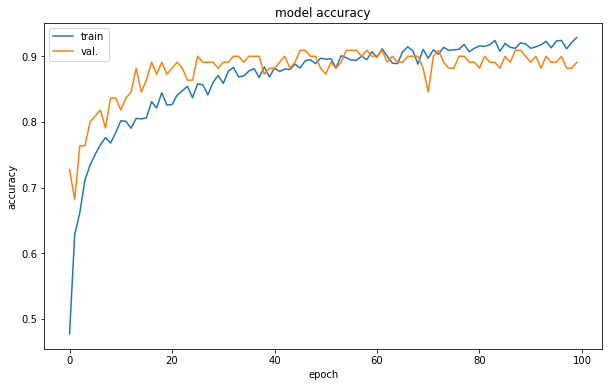

In [6]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 6

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val.'], loc='upper left')
plt.show()

### Check the testing accuracy

If it is similar to the validation accuracy, the model may be generalizing (which is good).

In [7]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.6227933420737585
Test accuracy: 0.87666667


### Check the per class FAR/POD

You can see that the high accuracy is mostly due to the model doing well on Cellular, QLCS, and Tropical cases. The model actually has fantastic POD (Sensitivity/Recall) overall, but higher FAR (An aspect of precision) for Cellular and Tropical cases.  At least for the test set, the model detects almost all QLCSs and has very few "QLCS False Alarms". This could be my bias towards identifying QLCSs, as I have been looking at images of QLCSs in my free time for..... longer than is healthy at this point.

76 out of 78 cellular cases, 144 out of 152 QLCS cases, and 31 out of 33 Tropical cases are properly identified!

11 Noise, 1 Missing, 3 Other, and 3 QLCSs cases are identified as Cellular (76 out of 94 (81%) Cellular Predictions were correct)

1 Noise, 2 Tropical, and 1 Cellular cases are identified as QLCS (144 out of 148 (97%) QLCS Predictions were correct)

1 Noise, 7 Other, 4 QLCS, and 1 Cellular cases are identified as Tropical (31 out of 44 (70%) Tropical Predictions were correct)

#### The other classes have very low counts, but these results suggest the classifications of Other, Missing, and Noise are not reliable. The work continues!

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

print('Confusion Matrix')
print(confusion_matrix(y_test_, y_pred))
print('Classification Report')
target_names = ['Cellular', 'QLCS', 'Tropical', 'Other', 'Missing', 'Noise']
print(classification_report(y_test_, y_pred, target_names=target_names))

Confusion Matrix
[[ 76   1   1   0   0   0]
 [  3 144   4   0   0   1]
 [  0   2  31   0   0   0]
 [  3   0   7   1   0   0]
 [  1   0   0   0   0   1]
 [ 11   1   1   0   0  11]]
Classification Report
              precision    recall  f1-score   support

    Cellular       0.81      0.97      0.88        78
        QLCS       0.97      0.95      0.96       152
    Tropical       0.70      0.94      0.81        33
       Other       1.00      0.09      0.17        11
     Missing       0.00      0.00      0.00         2
       Noise       0.85      0.46      0.59        24

    accuracy                           0.88       300
   macro avg       0.72      0.57      0.57       300
weighted avg       0.89      0.88      0.86       300



### Apply the model to the testing images and compare the predictions to the actual labels

In [10]:
from svrimg.utils.get_tables import get_svrgis_table, get_pred_tables

actual = get_pred_tables(data_dir="../data/csvs/", example=True, remove_first_row=True)

svrgis = get_svrgis_table(data_dir="../data/csvs/")

actual = actual.join(svrgis)

actual.head()

,Class Code,Class Name,om,tz,st,stf,stn,mag,inj,fat,...,f3,f4,fc,init_date,fmt_date,date_utc,yr,mo,dy,hr
UNID,,,,,,,,,,,,,,,,,,,,,
199604200208z000000206,0,Cellular,206,3,IL,17,38,0,0,0,...,0,0,0,1996-04-19-20:08:00,4/19/1996 20:08,4/20/1996 2:08,1996,4,20,2
199604192244z000000197,0,Cellular,197,3,IL,17,8,0,0,0,...,0,0,0,1996-04-19-16:44:00,4/19/1996 16:44,4/19/1996 22:44,1996,4,19,22
199605280130z000000300,0,Cellular,300,3,IL,17,49,0,0,0,...,0,0,0,1996-05-27-19:30:00,5/27/1996 19:30,5/28/1996 1:30,1996,5,28,1
199605280140z000000298,0,Cellular,298,3,IL,17,50,0,0,0,...,0,0,0,1996-05-27-19:40:00,5/27/1996 19:40,5/28/1996 1:40,1996,5,28,1
199604192307z000000207,0,Cellular,207,3,IL,17,11,2,1,0,...,0,0,0,1996-04-19-17:07:00,4/19/1996 17:07,4/19/1996 23:07,1996,4,19,23


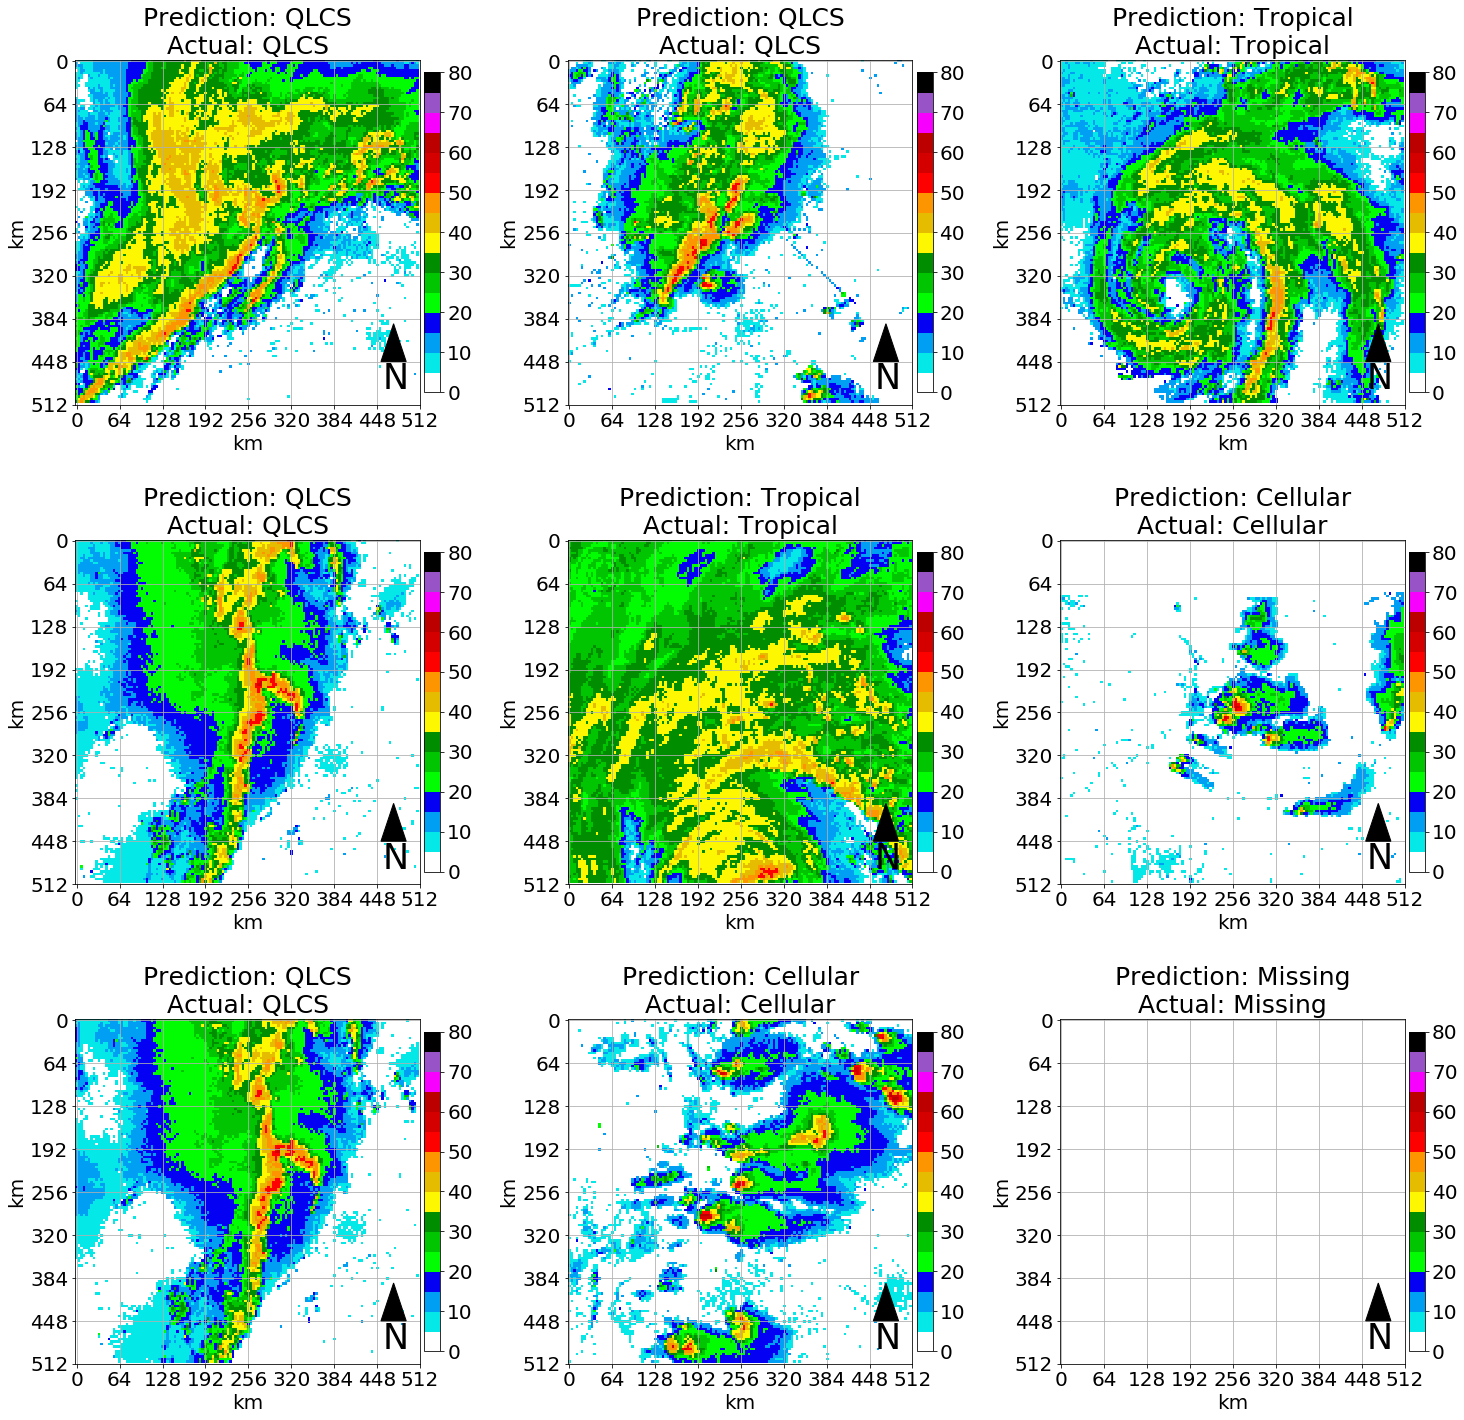

In [14]:
from svrimg.utils.get_images import get_img_list

plt.rcParams['figure.figsize'] = 25, 25
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20

#Testing data are 2014 and on.  It is "cheating" to look at earlier data.
sample = actual[actual.yr>=2014].sample(9)

#Load the images and transform them to be "CNN-friendly"
imgs = get_img_list(sample.index.values, "../data/tor/")
imgs = expand_dims(imgs, 3)
imgs = imgs / 80 #normalize

#Identify the column with the highest probability
pred = np.argmax(model.predict(imgs), axis=1)
truth = sample['Class Code'].values

lookup = {0:'Cellular', 1:'QLCS', 2:'Tropical', 3:'Other', 4:'Noise', 5:'Missing'}

for i, (img, p) in enumerate(zip(imgs, pred)):
    
    ax = plt.subplot(3, 3, i+1)
    
    ax = draw_box_plot(ax, img.squeeze()*80, cbar_shrink=0.8)
    
    ax.set_title("Prediction: {}\nActual: {}".format(lookup[p], lookup[truth[i]]), fontsize=25)

### Save model

In [15]:
model.save("../data/models/morph_model_v01.h5")